# Übung 4: (Lineare) Regression und Gradientenverfahren

## Vorbereitung

Als erstes importieren wir die Standardbibliotheken `numpy`, `pandas` und `matplotlib.pyplot`. Dann lesen wir den Datensatz `life_expectancy.csv` ein. Details über die Features sowie weitere Infos zum Datensatz findet ihr [hier](https://www.kaggle.com/kumarajarshi/life-expectancy-who). 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Wenn Du nicht mit Google Colab arbeitest, musst Du den folgenden Codeabschnitt natürlich anpassen
from google.colab import drive
drive.mount('/content/gdrive')

le_dataset = pd.read_csv('/content/gdrive/MyDrive/life_expectancy.csv')

Die nächste Zelle gibt euch die Spaltennamen des Datensatzes aus. Wie ihr seht, enthalten die Namen teilweise leicht zu übersehende Leerzeichen.

In [ ]:
le_dataset.columns

Die folgende Zelle enthält daher u.a. den `rename`-Befehl, der die Namen der Spalten anpasst und übersichtlicher macht. Darüber hinaus bereinigen wir den Datensatz, indem wir alle Zeilen löschen, in denen die Lebenserwartung nicht erfasst wurde und erstellen dann die Teildatensätze `le2013` und `le2006`, die nur die Daten aus den Jahren 2013 bzw. 2006 enthalten.


In [ ]:
le_dataset = le_dataset.rename(columns={"Life expectancy ": "LE", " BMI ": "BMI", "Measles ": "Measles", "Income composition of resources": "IcoR", "under-five deaths ": "u5d", "Diphtheria ": "Diphtheria", "Total expenditure": "TE", " HIV/AIDS": "HIV/AIDS", " thinness  1-19 years": "t1-19", " thinness 5-9 years": "t5-9"})
le_dataset = le_dataset[~le_dataset['LE'].isnull()]
le2013 = le_dataset[le_dataset['Year'].eq(2013)]
le2006 = le_dataset[le_dataset['Year'].eq(2006)]
le2006

Hier findet ihr eine Zelle, die der Datenvisualisierung dient. Durch Veränderung der Variable `fut` (feature under test) könnt ihr euch den Zusammenhang des entsprechenden features mit der Zielgröße Lebenserwartung anzuschauen.

In [ ]:
fut = 'Alcohol'

f,ax = plt.subplots(1,3,figsize=(32,8))
ax[0].plot(le_dataset[fut],le_dataset['LE'],'o')
ax[0].set_ylabel('LE',fontsize=24)
ax[0].set_title('Whole Dataset',fontsize=18)
ax[1].plot(le2006[fut],le2006['LE'],'o')
ax[1].set_title('Data from 2006',fontsize=18)
ax[2].plot(le2013[fut],le2013['LE'],'o')
ax[2].set_title('Data from 2013',fontsize=18)
f.text(0.5, 0.04, fut, ha='center',fontsize=24)

Zuletzt stellen wir euch noch die Funktion `add_constant(X)` zur Verfügung, die einer Input Matrix X eine zusätzliche Spalte bestehend aus Einsen hinzufügt. Das ist nützlich, wenn man bei einer linearen Regression eine Konstante berücksichtigen will.

In [ ]:
def add_constant(X):
  """
    Füge einer Input Matrix X eine zusätzliche Spalte bestehend aus Einsen hinzu

    :param pandas.dataframe X: Input Matrix
    :return: Input Matrix mit zusätzlicher Spalte an Position 0
  """

  if len(X.shape)>1:
    inp = np.ones((X.shape[0],1))
    inp = np.concatenate([inp,X],axis=1)
  else:
    inp = np.ones(X.shape)
    inp = np.concatenate([inp,X],axis=0).reshape((-1,2),order='F')
  return inp

Wie ihr in der Funktion `add_constant(X)` sehen könnt, wird hier eine Fallunterscheidung gemacht, je nachdem, ob es sich bei der betrachteten Größe um einen Vektor oder eine Matrix handelt. Dies ist für die Lösung der folgenden Aufgaben generell eine gute Idee, da viele Funktionen Inputs einer gewissen Form erwarten.

## 1. Einfache lineare Regression und Ridge Regression

Jetzt wollen wir eine erste einfache lineare Regression durchführen. Dafür wählen wir zunächst eine Menge an Funktionen $\mathcal F = \{f_1(\cdot),\dots,f_k(\cdot),\dots,f_K(\cdot)\}$ und wenden diese auf die Feature-Matrix $\boldsymbol X$ an, um entsprechende Transformationen zu erhalten. Die für eine lineare Regression entscheidende Annahme lautet, dass sich die Zielgröße $y$ durch eine Linearkombination der erzeugten Transformationen darstellen lässt. Fürs erste nehmen wir einfach $\mathcal F = \{x_i^{(1)},x_i^{(2)},\dots,x_i^{(t)}\}$ an.

Wenn $\boldsymbol x_i = [x_i^{(1)},x_i^{(2)},\dots,x_i^{(t)}]$ den Featurevektor und $y_i$ die Zielgröße jeweils zum Zeitpunkt $i$ darstellen, lässt sich der lineare Zusammenhang ausdrücken als:

> $y_i = \sum_k w_kf_k(\boldsymbol x_i)$

Und mit $\boldsymbol X = [\boldsymbol x_1,\dots,\boldsymbol x_i,\dots,\boldsymbol x_n]^T$ und $\boldsymbol y = [y_1,\dots,y_i,\dots, y_n]^T$ lautet die entsprechende Matrix-Notation:

> $\begin{bmatrix} y_1\\ y_2\\ \dots\\ y_n \end{bmatrix} = \begin{bmatrix} f_1(\boldsymbol x_1) & f_2(\boldsymbol x_1) & \dots & f_K(\boldsymbol x_1)\\ f_1(\boldsymbol x_2) & f_2(\boldsymbol x_2) & \dots & f_K(\boldsymbol x_2)\\ \dots & \dots & \dots & \dots\\ f_1(\boldsymbol x_n) & f_2(\boldsymbol x_n) & \dots & f_K(\boldsymbol x_n) \end{bmatrix}\begin{bmatrix} w_1\\ w_2\\ \dots\\ w_K \end{bmatrix}$

Das Ziel der linearen Regression ist jetzt, die Gewichte $\boldsymbol w = [w_1,w_2,\dots,w_K ]^T$ so zu bestimmen, dass der mittlere quadratische Fehler zwischen den berechneten und tatsächlichen $y$-Werten minimal ist.

**a)** Welche weitere Annahme wird bei der einfachen Linearen Regression getroffen?

**b)** Schreibe eine Funktion `lin_reg_OLS`, die aus den Eingabewerten Featurematrix `X` und Zielgröße `y` die optimalen Gewichte `w` nach dem *Ordinary Least Squares* Verfahren berechnet und zurück gibt.

**c)** Schreibe eine Funktion `MSE(X,y,w)`, die den mittleren quadratischen Fehler $\frac 1 n\sum_{i=1}^n(\boldsymbol x_i^T\boldsymbol w - y_i)^2$ berechnet.

**d)** Erstelle einen Scatter-Plot, in dem Du für die Daten aus dem Jahr 2013 die Lebenserwartung über der *Income composition of resources* plottest, einer Teilgröße des [Human Development Index](http://hdr.undp.org/en/content/human-development-index-hdi), die mit dem Bruttonationaleinkommen zusammen hängt. Im Datensatz heißt das Feature nach unserer Umbenennung `IcoR`. Berechne die zugehörige Regression und plotte die Regressionsgrade.

In [ ]:
# b)
def lin_reg_OLS(X,y):
  # Achtung: Hier ist eine Fallunterscheidung nötig, je nachdem, ob es sich bei 
  # X um eine Matrix oder einen Vektor handelt, weil die Matrixinversion bei einem
  # Vektor Probleme macht
  w = 0
  return w

# c)
def MSE(X,y,w):
  mean_square_error = 0
  return mean_square_error

In [ ]:
# Wir erstellen die zwei Datensätze für die Regression auf IcoR. Dafür löschen 
# wir nochmal alle Zeilen, in denen das relevante Feature 'IcoR' nicht erfasst wurde
le_dataset_IcoR = le2013[~le2013['IcoR'].isnull()]
le_dataset_IcoR2 = le2006[~le2006['IcoR'].isnull()]

In [ ]:
# d)


**e)** Verändere die Eingangsdaten jetzt so, dass bei der Regression eine Konstante berücksichtigt wird. Du kannst dafür die gegebene Funktion `add_constant` benutzen. Wie sieht jetzt die Funktionsmenge $\mathcal F$ aus? 

**f)** Erstelle einen weiteren Scatter-Plot, dieses mal mit den Daten aus dem Jahr 2015. Berechne den Fehler der in e) berechenten Regression zu diesen Daten.

In [ ]:
# e)

# f)


**g)** Schreibe jetzt eine Funktion `ridge_regression`, die aus den Inputs `X`. `y` und `lambda` die Gewichte der in der Vorlesung vorgestellten Ridge Regression berechnet. Welche zusätzliche Annahme wird bei der Ridge Regression getroffen? Wiederhole Aufgabenteil e) und f) jetzt mit der Ridge Regression und vergleiche die Ergebnisse.

**Tipp:** Um ein Gefühl für den Wert von `lambda` zu bekommen, muss häufig ein bisschen rumprobiert werden

In [ ]:
# g)
def ridge_regression(X,y,lam):
  w = 0
  return w

## Zusatzaufgabe (Optional):

Die folgende Zelle importiert einen weiteren Datensatz. Dieser enthält ein [PPG-Zeitsignal](https://en.wikipedia.org/wiki/Photoplethysmogram). Aus einem PPG-Signal kann man unter anderem den Puls bestimmen. Schaue dir das Signal genau an und führe dann eine Lasso Regression (`from sklearn.linear_model import Lasso`) auf dem Signal durch. Überlege dir, welche Funktionenmenge $\mathcal F$ dafür sinnvoll sein könnten und bestimme aus deiner Regression den Puls der Person.

Die Quelle des Datensatzes findet ihr [hier](https://www.kaggle.com/canaria/5-gamers?select=gamer1-ppg-2000-01-01.csv) oder alternativ im GitHub. Die Datei muss entpackt und in *ppg.csv* umbenannt werden, damit die Import-Zelle funktioniert.

In [ ]:
ppg_dataset = pd.read_csv('/content/gdrive/MyDrive/ppg.csv')[1990:2990]
Fs = 100 #sampling rate
ppg_dataset['Time'] = np.arange(0,10,1/Fs)

f,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(ppg_dataset['Time'],ppg_dataset['Red_Signal'],'o')
ax.set_xlabel('Time [s]',fontsize=20)
ax.set_ylabel('PPG',fontsize=20)

## 2. Gradient Descent

Implementiere jetzt das in der Vorlesung vorgestellte Gradientenabstiegsverfahren. 

**a)** Schreibe dazu eine Funktion `gradient_computation(X,y,w)`, die den Gradienten $\nabla L(\boldsymbol w)=2 \frac{1}n \sum_{i=1}^n\left(\boldsymbol x_i^T\boldsymbol w-\boldsymbol y_i\right)\boldsymbol x_i^T$ berechnet.

**b)** Schreibe dann eine Funktion `gradient_descent(X,y,initial_w,alpha)`, die basierend auf der Gradientenberechnung einen Gradientenabstieg mit Schrittweite $\alpha$ und den in `initial_w` übergebenen Initialgewichten durchführt.

**Hinweis:** Man sollte eine Abbruchbedingung definieren, damit die Funktion nicht endlos weiter läuft.

**c)** Führe danach für das Feature *Income composition of resources* bzw. *IcoR* einen Gradientenabstieg durch (mit Berücksichtigung einer Konstante) und vergleiche das Ergebnis zu dem aus Aufgabe 1. Variiere dabei die Parameter `alpha` und `initial_w` und beobachte was passiert.

In [ ]:
def gradient_compuatation(X,y,w):
  return 0

import copy

def gradient_descent(X,y,initial_w,alpha):
  w = copy.deepcopy(initial_w) # deepcopy ist nötig, um ein tatsächlich neues w zu erstellen und nicht nur auf initial_w zu referenzieren
  return w

## 3. Stochastic Gradient Descent und Adam

Implementiere jetzt den Stochastic Gradient Descent. 

**a)** Schreibe dafür die Funktionen `stochastic_gradient_computation(X,y,w,m)` und `stochastic_gradient_descent(X,y,initial_w,alpha,m)` mit dem Parameter `m`, der die Größe der Untermenge $M$ angibt. Du kannst die Funktionen `gradient_computation(X,y,w)` und `gradient_descent(X,y,initial_w,alpha)` aus Aufgabe 2 als Grundlage verwenden.

**b)** Führe einen stochastischen Gradientenabstieg wieder für das Feature *IcoR* durch (mit Berücksichtigung einer Konstante) und vergleiche das Ergebnis zu dem aus Aufgabe 2.

In [ ]:
import random

def stochastic_gradient_compuatation(X,y,w,m):
  return 0

def stochastic_gradient_descent(X,y,initial_w,alpha,m):
  w = copy.deepcopy(initial_w)
  return w

**c)** Implementiere abschließend den in der Vorlesung vorgestellten [Adam-Algorithmus](https://arxiv.org/pdf/1412.6980.pdf). Im Folgenden siehst Du nochmal eine Pseudo-Code Implementierung. Die Standartwerte für die Parameter können so übernommen werden.

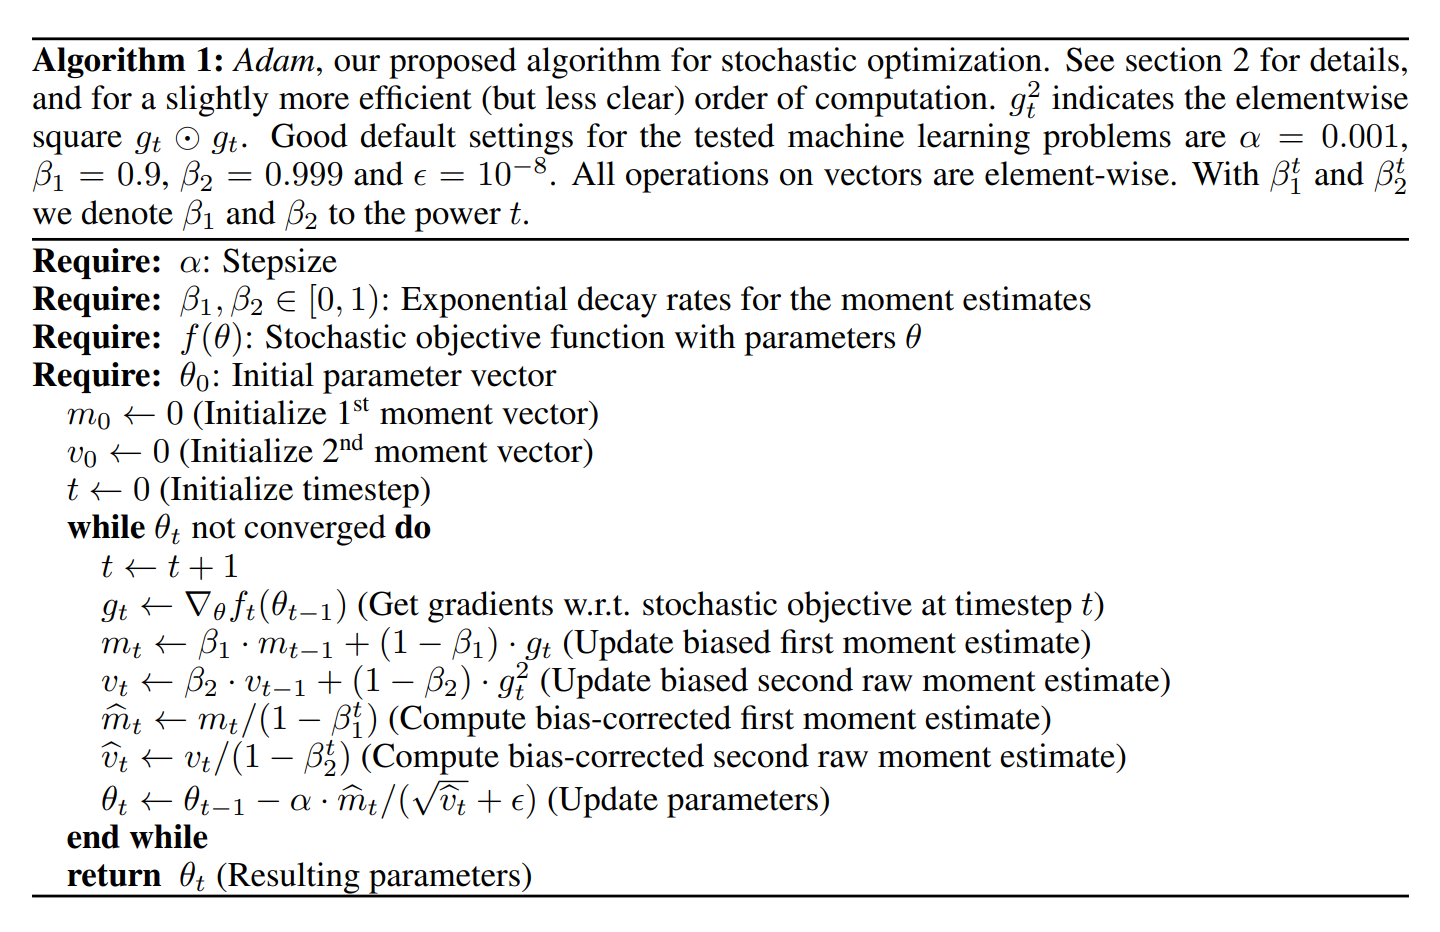

In [ ]:
epsilon = 1e-8;
beta_1 = 0.9;
beta_2 = 0.999;
alpha = 0.02;

m = np.array([0.0,0.0]).T
v = np.array([0.0,0.0]).T
w_adam = np.array([10.0,10.0]).T